# Hypothetical Scenario
Techmodal has been approached by a city council to help improve the efficiency of its public transport system. The city is facing **congestion**, **low satisfaction with bus routes**, and **rising operational costs**. You've been brought in to deliver **insights**, **simulations**, and **recommendations** using data and difital methods.


You have the role of a consultant on a discovery/delivery team and must engage with elements from all specialisms.

## Bristol is one of the UK's leading Smart Cities.
### Bristol uses data to drive decisions which improve the efficiency of the city.
### There are two main ways data is being used to improve efficiency:
1. Data is served directly to consumers which can influence consumer decisions.
2. Stored data is analysed to provide insights that drive operational changes.

![large-Smart_Cities_Graphic_1-8-05[1].png](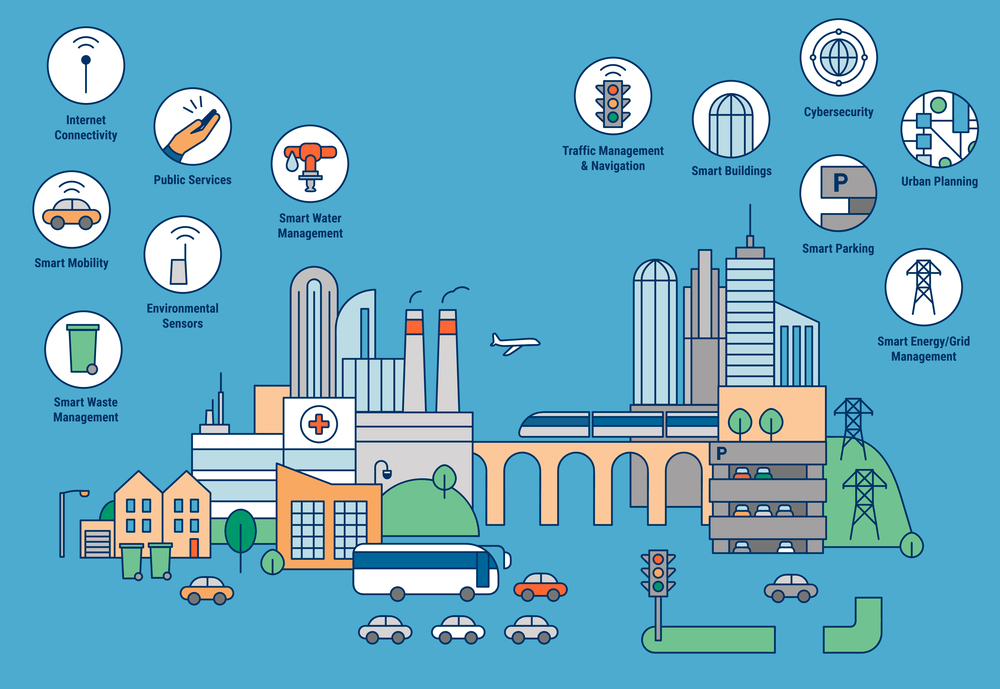)

### As a Data Engineer, your role is to identify, extract and transform data sources available to the local council. This represents the common ETL process depicted below.

![etl-process-explained-diagram[2].png](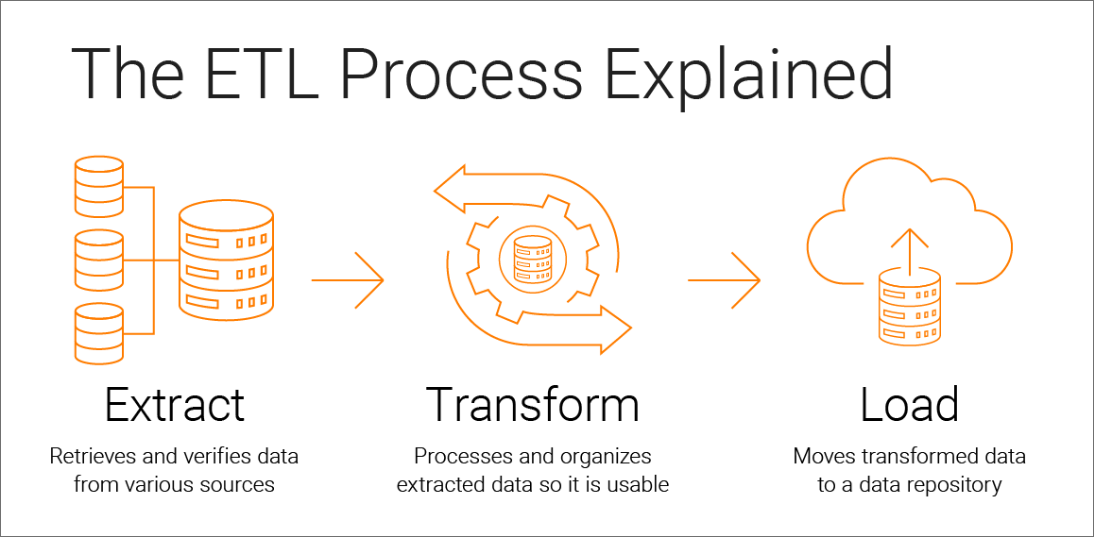)

# **Data Sources**

Before downloading data from the Bus Open Data Service (BODS):

**Obtain your API Key**: Sign up at https://data.bus-data.dft.gov.uk/account/signup/. Your API key will be located under "My Account > Account Settings".


**Store your API Key**: Create a new secret in your Colab environment named API_KEY and paste your API key as its value.


**Run the cells below** to download the necessary data into your Colab environment.

## API Sources

#### National Public Transport Access Nodes (NaPTAN)

In [ ]:
import requests
import os

# Create the ./data directory if it doesn't exist
download_dir = './data'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"Created directory: {download_dir}")

url = "https://naptan.api.dft.gov.uk/v1/access-nodes"
params = {
    "dataFormat": "CSV",
    "atcoAreaCodes": "010" # Area code for Bristol
}

# Send request to get data from the URL. The response is saved in the variable "response"
response = requests.get(url, params=params)

if response.status_code == 200:
  print("Successfully fetched data.")
  # You can process the CSV data from response.text or response.content
  with open('./data/naptan_bristol.csv', 'w') as f:
    f.write(response.text)
  print("Data written to naptan_bristol.csv")
else:
  print(f"Error fetching data. Status code: {response.status_code}")
  print(response.text) # Print the error message if available

In [ ]:
import pandas as pd

naptan_df = pd.read_csv('./data/naptan_bristol.csv')
naptan_df.tail()

#### Bus Open Data Service

##### Timetables Data API

In [ ]:
%pip install BODSDataExtractor
from BODSDataExtractor.extractor import TimetableExtractor
import os
import shutil
from datetime import date
from pathlib import Path

# Create the download directory if it doesn't exist
data_dir = './data'
download_dir = './Downloads'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"Created directory: {download_dir}")

my_bus_data_object = TimetableExtractor(api_key="dbc81239a91789de7a71be877fe42357c0cfff7a" # Your API Key Here
                                 ,limit=1 # How many datasets to view
                                 ,status = 'published' # Only view published datasets
                                 ,service_line_level=True # True if you require Service line data
                                 ,stop_level=False # True if you require stop level data
                                 ,atco_code=['010']
                                 )

#save the extracted service line level data to service_line_level variable
service_line_level = my_bus_data_object.service_line_extract

#note that in downloading the service line level data, the dataset level will also be downloaded. Can access this as below:
dataset_level = my_bus_data_object.metadata

#save these data to a csv file in your downloads directory
my_bus_data_object.save_metadata_to_csv()
my_bus_data_object.save_service_line_extract_to_csv()

# my_bus_data_object.save_timetables()

# Move the files
try:
    if os.path.exists(download_dir):
        shutil.move(download_dir, data_dir)
        print(f"Moved '{download_dir}' to '{data_dir}'")
    else:
        print(f"Warning: Metadata file '{source_folder}' not found.")

except Exception as e:
    print(f"An error occurred while moving files: {e}")

In [ ]:
import pandas as pd

target_directory = './data/Downloads'
today = str(date.today())
destination_folder = target_directory + '/' + today

pd.read_csv(f"{destination_folder}/service_line_extract.csv")

##### Location Data API

In [ ]:
url = "https://data.bus-data.dft.gov.uk/api/v1/datafeed"
params = {
    "api_key": "dbc81239a91789de7a71be877fe42357c0cfff7a",
    "boundingBox": "-2.5, 51.39, -2.7, 51.55"
    }

response = requests.get(url, params=params)

if response.status_code == 200:
  print("Successfully fetched location data.")
  with open("./data/bristol_bus_location_data.json", 'wb') as f:
    f.write(response.content)
    print("Data written to bristol_bus_location_data.json")

else:
  print(f"Error fetching location data. Status code: {response.status_code}")
  print(response.text)

In [ ]:
# Convert XML to CSV

import pandas as pd
import xml.etree.ElementTree as ET
import os

# --- Configuration ---
xml_filename = './data/bristol_bus_location_data.json'
csv_output_filename = './data/bristol_bus_location_data.csv'

# Namespace mapping (critical for correct XPath queries)
namespaces = {
    'siri': 'http://www.siri.org.uk/siri',
    'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
    # Add other namespaces if they appear in your full XML for elements you want to extract
    # 'ifopt': 'http://www.ifopt.org.uk/ifopt',
    # 'acsb': 'http://www.ifopt.org.uk/acsb',
}

# --- Load the XML file ---
try:
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    print(f"Successfully loaded XML from '{xml_filename}'.")
except FileNotFoundError:
    print(f"Error: '{xml_filename}' not found. Please ensure the file exists in the same directory.")
    exit() # Exit the script if the file isn't found
except ET.ParseError as e:
    print(f"Error: Could not parse '{xml_filename}'. It might be malformed or incomplete.")
    print(f"Parsing error details: {e}")
    exit() # Exit if parsing fails
except Exception as e:
    print(f"An unexpected error occurred while loading or parsing the XML: {e}")
    exit()

# --- Define a list to hold the extracted data ---
data = []

# --- Extract data from VehicleActivity elements ---
# Use a robust XPath to find all VehicleActivity elements regardless of exact depth
print("Starting data extraction from XML...")
for vehicle_activity in root.findall('.//siri:VehicleActivity', namespaces):
    record = {}

    # Extract fields directly under VehicleActivity
    record['RecordedAtTime'] = vehicle_activity.find('siri:RecordedAtTime', namespaces).text
    record['ItemIdentifier'] = vehicle_activity.find('siri:ItemIdentifier', namespaces).text
    record['ValidUntilTime'] = vehicle_activity.find('siri:ValidUntilTime', namespaces).text

    # Navigate to MonitoredVehicleJourney
    mvj = vehicle_activity.find('siri:MonitoredVehicleJourney', namespaces)
    if mvj is not None:
        record['LineRef'] = mvj.find('siri:LineRef', namespaces).text
        record['DirectionRef'] = mvj.find('siri:DirectionRef', namespaces).text
        record['PublishedLineName'] = mvj.find('siri:PublishedLineName', namespaces).text
        record['OperatorRef'] = mvj.find('siri:OperatorRef', namespaces).text
        record['OriginRef'] = mvj.find('siri:OriginRef', namespaces).text
        record['OriginName'] = mvj.find('siri:OriginName', namespaces).text
        record['DestinationRef'] = mvj.find('siri:DestinationRef', namespaces).text
        record['DestinationName'] = mvj.find('siri:DestinationName', namespaces).text
        record['VehicleRef'] = mvj.find('siri:VehicleRef', namespaces).text

        # Extract FramedVehicleJourneyRef details
        framed_vj_ref = mvj.find('siri:FramedVehicleJourneyRef', namespaces)
        if framed_vj_ref is not None:
            record['DataFrameRef'] = framed_vj_ref.find('siri:DataFrameRef', namespaces).text
            record['DatedVehicleJourneyRef'] = framed_vj_ref.find('siri:DatedVehicleJourneyRef', namespaces).text
        else:
            record['DataFrameRef'] = None
            record['DatedVehicleJourneyRef'] = None

        # Extract VehicleLocation coordinates
        vehicle_location = mvj.find('siri:VehicleLocation', namespaces)
        if vehicle_location is not None:
            record['Latitude'] = vehicle_location.find('siri:Latitude', namespaces).text
            record['Longitude'] = vehicle_location.find('siri:Longitude', namespaces).text
        else:
            record['Latitude'] = None
            record['Longitude'] = None
    else:
        # If MonitoredVehicleJourney is missing, set all its sub-fields to None
        for key in ['LineRef', 'DirectionRef', 'PublishedLineName', 'OperatorRef', 'OriginRef', 'OriginName',
                     'DestinationRef', 'DestinationName', 'OriginAimedDepartureTime', 'DestinationAimedArrivalTime',
                     'Bearing', 'BlockRef', 'VehicleRef', 'DataFrameRef', 'DatedVehicleJourneyRef', 'Latitude', 'Longitude']:
            record[key] = None

    # Extract data from Extensions (Note: custom extensions might not use SIRI namespace for inner tags)
    extensions = vehicle_activity.find('siri:Extensions', namespaces)
    if extensions is not None:
        # Search for VehicleJourney anywhere within Extensions' subtree
        vehicle_journey_ext = extensions.find('.//VehicleJourney') # No namespace for custom extension root
        if vehicle_journey_ext is not None:
            operational = vehicle_journey_ext.find('.//Operational') # No namespace for custom Operational
            if operational is not None:
                ticket_machine = operational.find('.//TicketMachine') # No namespace for custom TicketMachine
                if ticket_machine is not None:
                    record['TicketMachineServiceCode'] = ticket_machine.find('.//TicketMachineServiceCode').text
                    record['JourneyCode'] = ticket_machine.find('.//JourneyCode').text
                else:
                    record['TicketMachineServiceCode'] = None
                    record['JourneyCode'] = None
            else:
                record['TicketMachineServiceCode'] = None
                record['JourneyCode'] = None

            record['VehicleUniqueId'] = vehicle_journey_ext.find('.//VehicleUniqueId').text
        else:
            record['TicketMachineServiceCode'] = None
            record['JourneyCode'] = None
            record['VehicleUniqueId'] = None
    else:
        # If Extensions are missing, set all its sub-fields to None
        record['TicketMachineServiceCode'] = None
        record['JourneyCode'] = None
        record['VehicleUniqueId'] = None

    # Append the record to the list, converting None to actual None values
    # We set default values for all possible keys in the record to ensure all columns exist.
    # If an element is not found, its value will be None.
    for key, value in record.items():
        if value is None:
            record[key] = None # Ensure None if text is not found
        else:
            # Clean up whitespace from text
            record[key] = value.strip()

    data.append(record)

# --- Create a pandas DataFrame ---
if data:
    df = pd.DataFrame(data)

    # --- Save the DataFrame to a CSV file ---
    df.to_csv(csv_output_filename, index=False, encoding='utf-8')

    print(f"\nData successfully converted from XML and saved to '{csv_output_filename}'")

    # Display the first few rows of the generated CSV (optional)
    print("\nFirst 5 rows of the converted CSV:")
    print(df.head())

else:
    print("No vehicle activity data was extracted from the XML. The output CSV will not be created.")

## Flat file Sources



### CSV Files

#### VivaCity Sensors

In [ ]:
import requests

file_url = "https://hub.arcgis.com/api/v3/datasets/fd1ce15130e845bfabcc531cb404d122_1/downloads/data?format=csv&spatialRefId=27700&where=1%3D1"
# Define the desired local filename
output_filename = "./data/VivaCity_sensor.csv"

print(f"Attempting to download file from: {file_url}")

try:
    # Send a GET request to the URL
    # stream=True allows iterating over the response content, useful for large files
    response = requests.get(file_url, stream=True, timeout=60)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    # Open the local file in binary write mode ('wb')
    with open(output_filename, 'wb') as f:
        # Iterate over the response content in chunks
        # This is memory efficient for large files
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Successfully downloaded and saved as '{output_filename}'")

except requests.exceptions.Timeout:
    print(f"Error: The download timed out after 60 seconds.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except IOError as e:
    print(f"Error writing the file to disk: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
import pandas as pd

traffic_sensors = pd.read_csv("./data/VivaCity_sensor.csv")
traffic_sensors.head()

#### Bristol Historic Journey Time

In [ ]:
import requests

file_url = "https://www.arcgis.com/sharing/rest/content/items/5e20d88411ef457996c820f07167fc2c/data"
# Define the desired local filename
output_filename = "./data/bristol_historic_journey_time.csv"

print(f"Attempting to download file from: {file_url}")

try:
    # Send a GET request to the URL
    # stream=True allows iterating over the response content, useful for large files
    response = requests.get(file_url, stream=True, timeout=60)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    # Open the local file in binary write mode ('wb')
    with open(output_filename, 'wb') as f:
        # Iterate over the response content in chunks
        # This is memory efficient for large files
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Successfully downloaded and saved as '{output_filename}'")

except requests.exceptions.Timeout:
    print(f"Error: The download timed out after 60 seconds.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except IOError as e:
    print(f"Error writing the file to disk: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
import pandas as pd

traffic_sensors = pd.read_csv("./data/bristol_historic_journey_time.csv")
traffic_sensors.head()

### GeoJSON files

In [ ]:
import requests

file_url = "https://hub.arcgis.com/api/v3/datasets/fd1ce15130e845bfabcc531cb404d122_1/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
# Define the desired local filename
output_filename = "./data/VivaCity_sensor.geojson"

print(f"Attempting to download file from: {file_url}")

try:
    # Send a GET request to the URL
    # stream=True allows iterating over the response content, useful for large files
    response = requests.get(file_url, stream=True, timeout=60)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    # Open the local file in binary write mode ('wb')
    with open(output_filename, 'wb') as f:
        # Iterate over the response content in chunks
        # This is memory efficient for large files
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Successfully downloaded and saved as '{output_filename}'")

except requests.exceptions.Timeout:
    print(f"Error: The download timed out after 60 seconds.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except IOError as e:
    print(f"Error writing the file to disk: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
%pip install folium

import folium
import json
import os

# Define the path to your GeoJSON file
geojson_path = './data/VivaCity_sensor.geojson'

# Check if the file exists
if not os.path.exists(geojson_path):
    print(f"Error: The file '{geojson_path}' was not found.")
else:
    # Load the GeoJSON file
    try:
        with open(geojson_path, 'r') as f:
            geojson_data = json.load(f)

        # Create a Folium map centered around a reasonable location (e.g., Bristol)
        # You might need to adjust the center coordinates based on your data
        m = folium.Map(location=[51.454252, -2.587910], zoom_start=12) # Example coordinates for Bristol

        # Add the GeoJSON data to the map
        # If the GeoJSON has features, they will be added as points, lines, or polygons
        folium.GeoJson(
            geojson_data,
            name='VivaCity Sensors'
        ).add_to(m)

        # Add a layer control to toggle the GeoJSON layer (optional)
        folium.LayerControl().add_to(m)

        # Display the map
        print("Displaying the map with VivaCity sensor locations:")
        display(m)

    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{geojson_path}'. Please ensure it's a valid GeoJSON file.")
    except Exception as e:
        print(f"An error occurred while processing the GeoJSON file: {e}")

# **Data Processing**

#### Data Cleansing Functions

In [ ]:
# --- Viewing Your Data ---

# Useful Pandas Methods for viewing data

print("--- 2. Viewing Your Data ---")

# .head() - View the first few rows (default is 5)
print("First 3 rows (df.head(3)):")
print(df.head(3))

# .tail() - View the last few rows (default is 5)
print("\nLast 2 rows (df.tail(2)):")
print(df.tail(2))

# .info() - Get a summary of the DataFrame (data types, non-null counts)
print("\nDataFrame Info (df.info()):")
df.info()

# .describe() - Get descriptive statistics for numeric columns
print("\nDescriptive Statistics (df.describe()):")
print(df.describe())

# .shape - Get the number of rows and columns (returns a tuple: (rows, columns))
print(f"\nDataFrame Shape (df.shape): {df.shape} (rows, columns)")

# .columns - Get a list of column names
print(f"Column Names (df.columns): {df.columns.tolist()}")

# .isnull().sum() - Count missing values per column
print("\nMissing Values per Column (df.isnull().sum()):")
print(df.isnull().sum())

print("\n" + "="*50 + "\n")


In [ ]:
# --- Manipulating Data ---

# Useful functions for manipulating data

# Add a new column
df['COL_NAME'] = [False]
print(df)

# Modify an existing numerical column
df['COL_NAME'] = df['COL_NAME'] + 1
print(df)

# Modify a column type to datetime
df['Mycol'] = pd.to_datetime(df['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

# Change column type to numeric
df['Mycol'] = pd.to_numeric(df['Mycol'])

# Create an average of a numerical column
average_score = df['COL_NAME'].mean()
print(df)

# Rename columns
df.rename(columns={'COL_NAME': 'COL_NAME', 'COL_NEW_NAME': 'COL_NEW_NAME'}, inplace=True)
print(df)

# Drop columns (axis=1 means columns, axis=0 means rows)
df_no_student = df.drop(columns=['COL_NAME']) # Creates a new DataFrame without 'COL_NAME'
print(df_no_student)

# Drop rows
# Let's drop the row where COL_NAME is X, where X is a numerical value
df_no_COL_NAME= df[df['COL_NAME'] != 23]
print("\nDataFrame after dropping row where Age is 23 (Charlie):")
print(df_no_COL_NAME)

# Sort values
print("\nDataFrame sorted by 'COL_NAME' (ascending):")
print(df.sort_values(by='COL_NAME'))

print("\nDataFrame sorted by 'COL_NAME' (descending):")
print(df.sort_values(by='COL_NAME', ascending=False))

print("\n" + "="*50 + "\n")


In [ ]:
import pandas as pd

# Define the path to your CSV file
file_path = 'file_name.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

print(f"'{file_path}' loaded successfully into a DataFrame.")
print("\nFirst 5 rows of the DataFrame:")
print(df.head())